In [ ]:
import os
import glob
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parametri
model_name = "ResNet18"
checkpoint_dir = f"../checkpoints/{model_name}"
checkpoint_files = sorted(glob.glob(os.path.join(checkpoint_dir, "log_epoch_*.pt")))

In [13]:
# Caricamento dati
logs = []
for file in checkpoint_files:
    ckpt = torch.load(file, map_location="cpu")
    logs.append({
        "epoch": ckpt["epoch"] + 1,
        "val_acc_species": ckpt["actual_val_acc_species"],
        "val_acc_disease": ckpt["actual_val_acc_disease"],
        "val_acc_avg": ckpt["actual_val_avg_acc"],
        "best_val_acc_species": ckpt["best_val_acc_species"],
        "best_val_acc_disease": ckpt["best_val_acc_disease"],
        "best_val_acc_avg": ckpt["best_val_acc_avg"]
    })

df = pd.DataFrame(logs)
df = df.sort_values(by="epoch").reset_index(drop=True)

# Visualizza i dati grezzi
df.head()


/var/folders/td/v7jn9s9n1rb36krxbncpn2mr0000gn/T/ipykernel_58752/2694915698.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")


,epoch,val_acc_species,val_acc_disease,val_acc_avg,best_val_acc_species,best_val_acc_disease,best_val_acc_avg
0,1,0.856154,0.794506,0.825330,0.856154,0.794506,0.825330
1,2,0.616908,0.704003,0.660456,0.856154,0.794506,0.825330
2,3,0.830281,0.674936,0.752609,0.856154,0.794506,0.825330
3,4,0.943888,0.853066,0.898477,0.943888,0.853066,0.898477
4,5,0.912585,0.801959,0.857272,0.943888,0.853066,0.898477


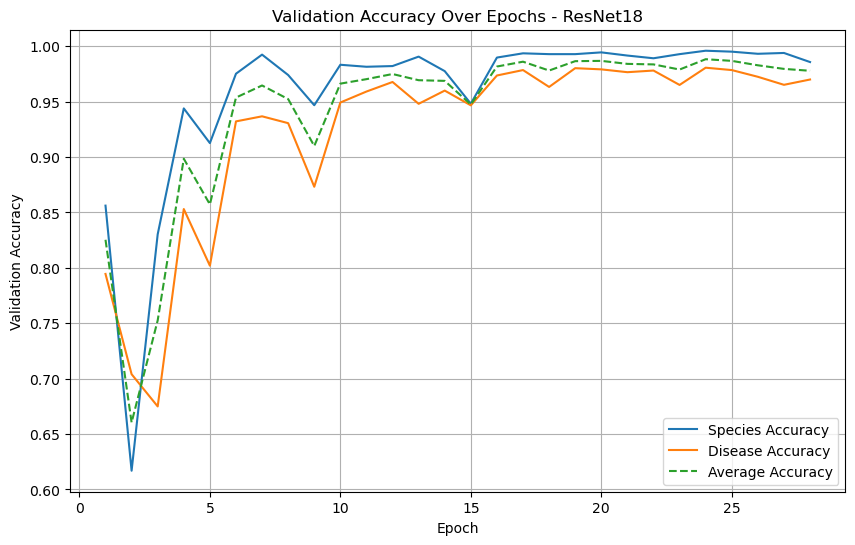

In [14]:
# Plot andamenti di accuratezza
plt.figure(figsize=(10, 6))
plt.plot(df["epoch"], df["val_acc_species"], label="Species Accuracy")
plt.plot(df["epoch"], df["val_acc_disease"], label="Disease Accuracy")
plt.plot(df["epoch"], df["val_acc_avg"], label="Average Accuracy", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title(f"Validation Accuracy Over Epochs - {model_name}")
plt.legend()
plt.grid(True)
plt.show()

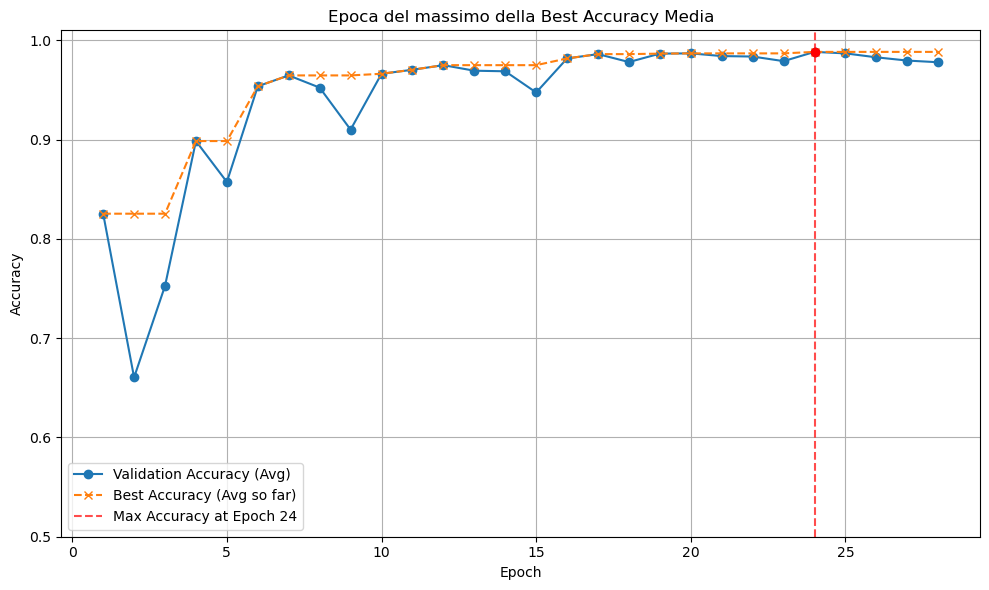

Best Accuracy Mean: 0.9883 at Epoch 24


In [20]:
# 2. Confronto tra Accuracy media e Best Accuracy

# Trova la riga in cui si raggiunge la migliore accuracy media
best_row = df.loc[df["best_val_acc_avg"].idxmax()]
best_epoch = best_row["epoch"]
best_acc = best_row["best_val_acc_avg"]

plt.figure(figsize=(10, 6))
plt.plot(df["epoch"], df["val_acc_avg"], label="Validation Accuracy (Avg)", marker='o')
plt.plot(df["epoch"], df["best_val_acc_avg"], label="Best Accuracy (Avg so far)", linestyle='--', marker='x')

# Evidenzia il punto di massimo
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f"Max Accuracy at Epoch {int(best_epoch)}")
plt.scatter(best_epoch, best_acc, color='red', zorder=5)

plt.title("Epoca del massimo della Best Accuracy Media")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.01)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Stampa a parte (opzionale)
print(f"Best Accuracy Mean: {best_acc:.4f} at Epoch {int(best_epoch)}")

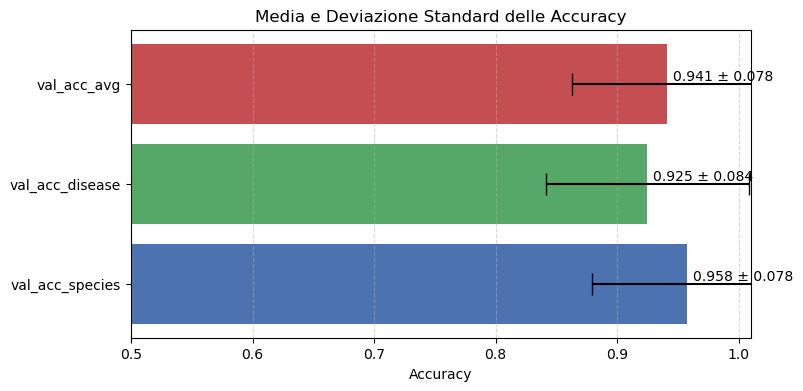

In [28]:
# 3. Calcolo delle medie e deviazioni standard

import numpy as np
import matplotlib.pyplot as plt

# Calcolo statistiche
metrics = ["val_acc_species", "val_acc_disease", "val_acc_avg"]
means = [df[m].mean() for m in metrics]
stds = [df[m].std() for m in metrics]

# Bar plot con errori
plt.figure(figsize=(8, 4))
plt.barh(metrics, means, xerr=stds, color=["#4c72b0", "#55a868", "#c44e52"], capsize=8)
plt.xlabel("Accuracy")
plt.title("Media e Deviazione Standard delle Accuracy")
plt.xlim(0.5, 1.01)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Etichette sulle barre
for i, (m, s) in enumerate(zip(means, stds)):
    plt.text(m + 0.005, i, f"{m:.3f} ± {s:.3f}", va="bottom")

plt.show()

Miglioramento medio per epoca: 0.0056
Deviazione standard: 0.0535


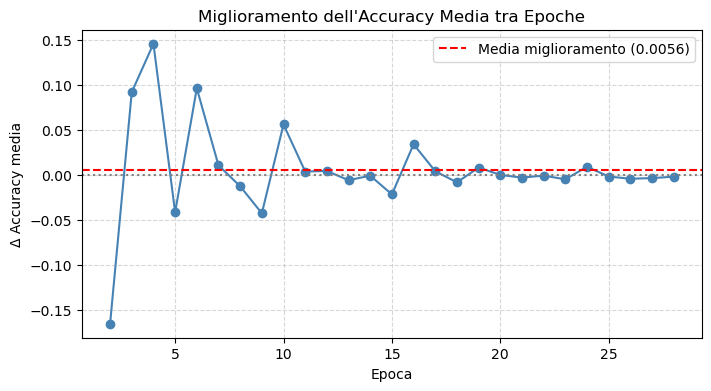

In [29]:
# Calcolo del miglioramento epoca per epoca
df["delta_avg_acc"] = df["val_acc_avg"].diff()  # differenza con epoca precedente

# Rimuove la prima riga (che ha NaN come differenza)
delta_df = df.dropna(subset=["delta_avg_acc"])

# Statistiche descrittive
mean_improvement = delta_df["delta_avg_acc"].mean()
std_improvement = delta_df["delta_avg_acc"].std()

print(f"Miglioramento medio per epoca: {mean_improvement:.4f}")
print(f"Deviazione standard: {std_improvement:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(delta_df["epoch"], delta_df["delta_avg_acc"], marker="o", linestyle="-", color="steelblue")
plt.axhline(mean_improvement, color="red", linestyle="--", label=f"Media miglioramento ({mean_improvement:.4f})")
plt.axhline(0, color="gray", linestyle=":")
plt.title("Miglioramento dell'Accuracy Media tra Epoche")
plt.xlabel("Epoca")
plt.ylabel("Δ Accuracy media")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [30]:
# Lista dei modelli che vuoi confrontare
model_names = ["ResNet18", "ViT", "CLIPResNet", "CLIPViT", "DINOv2"]  # aggiungi o rimuovi se necessario
all_logs = []

for model_name in model_names:
    checkpoint_dir = f"../checkpoints/{model_name}"  # cambia il path se sei in notebooks/
    checkpoint_files = sorted(glob.glob(os.path.join(checkpoint_dir, "log_epoch_*.pt")))
    
    for file in checkpoint_files:
        ckpt = torch.load(file, map_location="cpu")
        all_logs.append({
            "model": model_name,
            "epoch": ckpt["epoch"] + 1,
            "val_acc_avg": ckpt["actual_val_avg_acc"],
            "val_acc_species": ckpt["actual_val_acc_species"],
            "val_acc_disease": ckpt["actual_val_acc_disease"]
        })

df_all = pd.DataFrame(all_logs)
df_all = df_all.sort_values(by="epoch").reset_index(drop=True)

/var/folders/td/v7jn9s9n1rb36krxbncpn2mr0000gn/T/ipykernel_58752/1766139725.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")


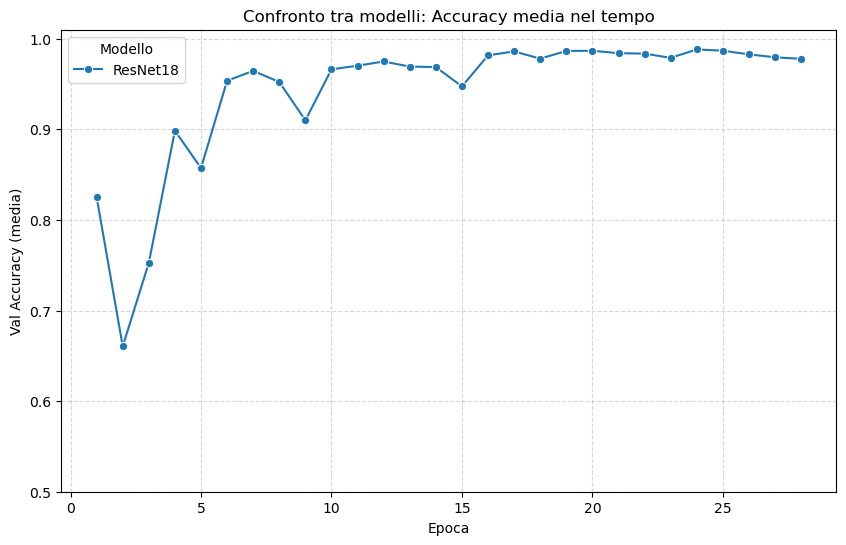

In [31]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_all, x="epoch", y="val_acc_avg", hue="model", marker="o")
plt.title("Confronto tra modelli: Accuracy media nel tempo")
plt.xlabel("Epoca")
plt.ylabel("Val Accuracy (media)")
plt.ylim(0.5, 1.01)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Modello")
plt.show()

In [33]:
summary = df_all.groupby("model")["val_acc_avg"].agg(["max", "mean", "std"]).sort_values("max", ascending=False)
summary.rename(columns={"max": "Max Accuracy", "mean": "Mean Accuracy", "std": "Std Dev"}, inplace=True)
summary

,Max Accuracy,Mean Accuracy,Std Dev
model,,,
ResNet18,0.988288,0.94117,0.078346
